# Super-Resolution Convolutional Neural Network training

Here in this jupyter notebook, we will train a super-resolution convolutional neural network (SRCNN), to create high-resolution bed Digital Elevation Model(DEM) from a low-resolution DEM.

Y (low-res DEM) --(SRCNN)--> Y-hat (predicted high-res DEM) <-(minimize loss)--> X (groundtruth high-res DEM)

## 0. Setup libraries

In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import quilt
import skimage.transform
%matplotlib inline

import keras
from keras import backend as K
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from livelossplot import PlotLossesKeras

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)

Using TensorFlow backend.


Python       : 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
Numpy        : 1.14.5
Keras        : 2.2.2


## 1. Load data

In [2]:
hash = '42a7d65fab8d6d3dfba3091ff86d70580b842a7efc6f801e26b1e359a3164d33'
quilt.install(package='weiji14/deepbedmap/model/train', hash=hash, force=False)
pkg = quilt.load(pkginfo='weiji14/deepbedmap', hash=hash)

weiji14/deepbedmap/model/train already installed.


Overwrite? (y/n)  n


In [3]:
X_data = pkg.model.train.X_data()  #high resolution
Y_data = pkg.model.train.Y_data()  #low resolution BEDMAP2
print(X_data.shape, Y_data.shape)

(371, 32, 32, 1) (371, 8, 8, 1)


## 2. Architect model

Fast SRCNN model based on [Dong et al. 2016](https://arxiv.org/abs/1608.00367).
Original Matlab and Caffe code from paper is [here](http://mmlab.ie.cuhk.edu.hk/projects/FSRCNN.html).
Keras implementation below takes some hints from https://github.com/GeorgeSeif/FSRCNN-Keras.

![FSRCNN model visualization](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/391726/x2.png)

In [4]:
def fsrcnn_model(input_shape:tuple=(8,8,1), scaling:int=4):
    """
    Fast Super Resolution Convolutional Neural Network (FSRCNN) model.
    Architected using Keras, with a tensorflow backend.
    
    Takes an input low-resolution image of shape (8,8,1).
    Outputs a high-resolution image of shape (64,64,1).
    I.e. An 8x scaling factor.
    """
    ## Input low-resolution image
    inp = Input(shape=input_shape)
    assert(inp.shape.ndims == 4) #needs to be shape like (?,8,8,1) for 8x8 grid
    
    ## Pass image through convolution layers
    ## FSRCNN(56,12,4), FSRCNN(d,s,m) where d=feature dimension/filters, s=shrinking filters, m=mapping depth
    
    # 1st part
    # feature extraction
    X = Conv2D(filters=56, kernel_size=(5,5), strides=(1,1), padding='same', name='conv1')(inp)
    X = PReLU()(X)
    
    # 2nd part
    # shrinking
    X = Conv2D(filters=12, kernel_size=(1,1), strides=(1,1), padding='same', name='conv2')(X)
    X = PReLU()(X)
    
    # non-linear mapping 
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv22')(X)
    X = PReLU()(X)
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv23')(X)
    X = PReLU()(X)
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv24')(X)
    X = PReLU()(X)
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv25')(X)
    X = PReLU()(X)
    
    # expanding
    X = Conv2D(filters=56, kernel_size=(1,1), strides=(1,1), padding='same', name='conv26')(X)
    X = PReLU()(X)
    
    # 3rd part
    # deconvolution
    outp = Conv2DTranspose(filters=1, kernel_size=(9,9), strides=(scaling,scaling), padding='same', name='conv3')(X)
    
    # Create model with input low-res image and output prediction
    model = Model(inputs=inp, outputs=[outp])
   
    return model

In [5]:
# Peak Signal-Noise Ratio (PSNR) metric https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
def psnr(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis=-1)
    return 20 * K.log(2**16/K.sqrt(mse))  #setting MAX_I as 2^16, i.e. max for int16

In [6]:
model = fsrcnn_model()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mse, metrics=[psnr, keras.metrics.mean_squared_error])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 1)           0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 56)          1456      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 8, 8, 56)          3584      
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 12)          684       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 8, 8, 12)          768       
_________________________________________________________________
conv22 (Conv2D)              (None, 8, 8, 12)          1308      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 8, 8, 12)          768       
__________

## 3. Train model

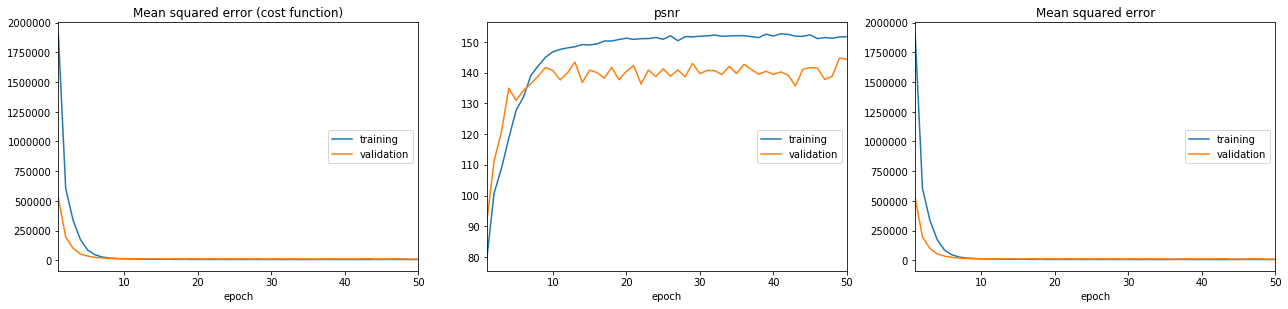

In [7]:
tensorboard = keras.callbacks.TensorBoard(log_dir='model/logs', histogram_freq=1, write_graph=True)
model.fit(x=Y_data, y=X_data, verbose=1, validation_split=0.05, batch_size=32,
          epochs=50, callbacks=[tensorboard, PlotLossesKeras(max_cols=3)])

In [8]:
raise ValueError('temp')

ValueError: temp

## 4. Evaluate model

In [ ]:
Y_hat = model.predict(x=Y_data, verbose=1)
print(Y_hat.shape, Y_hat.dtype)

In [ ]:
for i in range(5):
    try:
        id = random.randrange(0,len(Y_data))
        print(id, Y_data[id].shape)
        
        Y_cube = skimage.transform.rescale(image=Y_data[id].astype(np.int32), scale=4, order=3, mode='reflect', anti_aliasing=True, multichannel=False)
        
        fig, axarr = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(15,15))
        axarr[0, 0].imshow(Y_data[id][:,:,0], aspect='equal')
        axarr[0, 1].imshow(Y_cube[:,:,0], aspect='equal')
        axarr[0, 2].imshow(Y_hat[id][:,:,0], aspect='equal')
        axarr[0, 3].imshow(X_data[id][:,:,0], aspect='equal')
        plt.show()
    except TypeError:
        pass